In [14]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [15]:
df = pd.DataFrame()
for i in range(13):
    file_name = 'events_England_' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'socceranalytics', 'Wyscout', file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)
print(path)

D:\socceranalytics\Wyscout\events_England_13.json


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


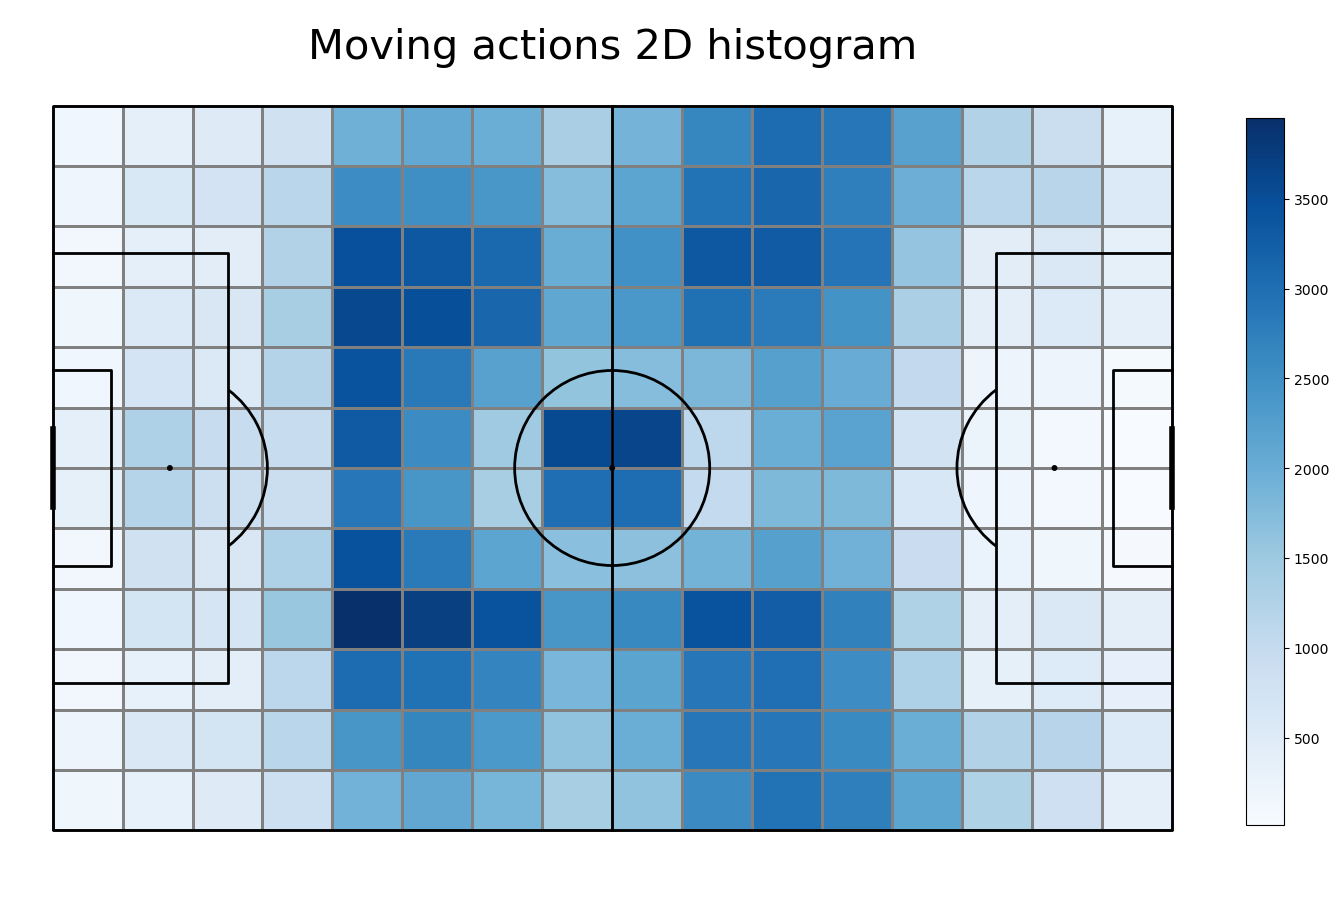

In [17]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]

df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
#get move_df
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

In [19]:
move_df.count()

eventId         307333
subEventName    307333
tags            307333
playerId        307333
positions       307333
matchId         307333
eventName       307333
teamId          307333
matchPeriod     307333
eventSec        307333
subEventId      307333
id              307333
nextEvent       307333
kickedOut       307333
x               307333
y               307333
end_x           307333
end_y           307333
dtype: int64

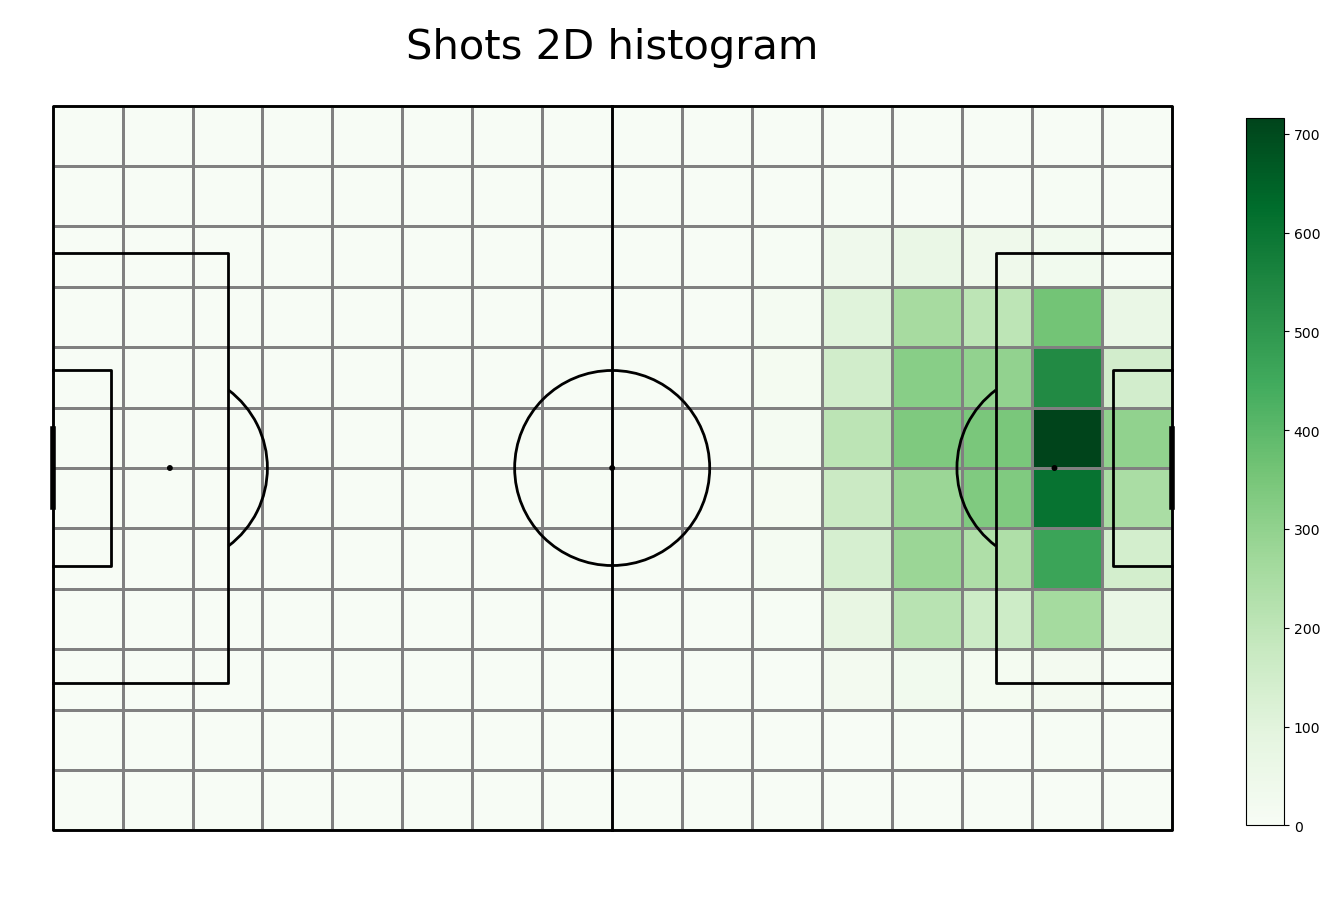

{'statistic': array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           3.,   2.,   2.,   5.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   7.,
          40.,  67.,  43.,  33.,   4.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,  16.,
         105., 256., 204., 359.,  67.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,  17.,
         151., 317., 297., 538., 147.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,  14.,
         206., 338., 346., 716., 301.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   0.,  13.,
         169., 280., 333., 608., 248.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,  15.,
         137., 282., 237., 465., 145.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.

In [37]:
shot_df = df.loc[df["subEventName"]=="Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()
#get the array
shot_count = shot["statistic"]

shot

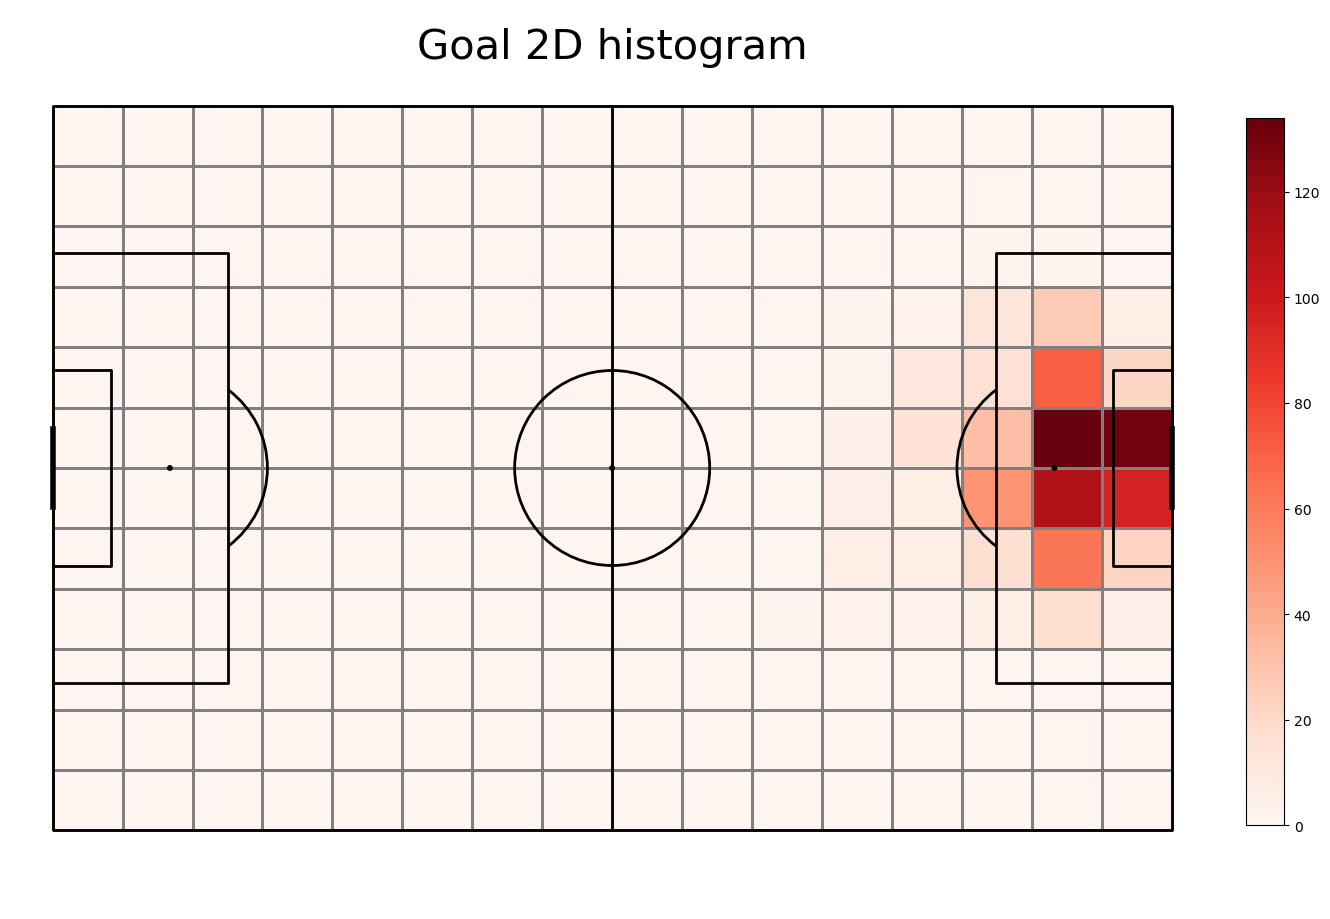

In [28]:
goal_df = shot_df.loc[shot_df.apply(lambda x: {'id': 101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()


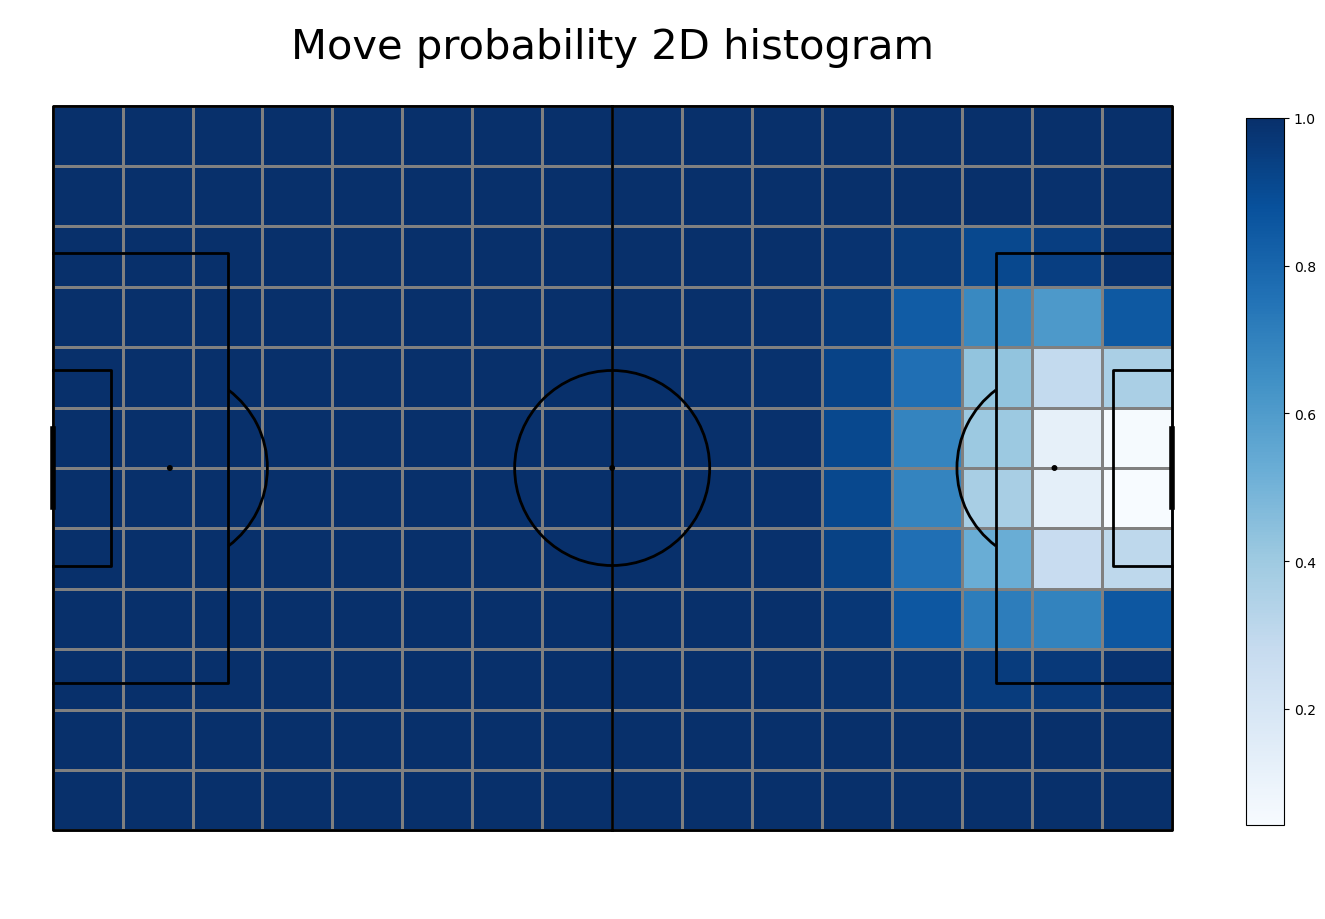

In [31]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

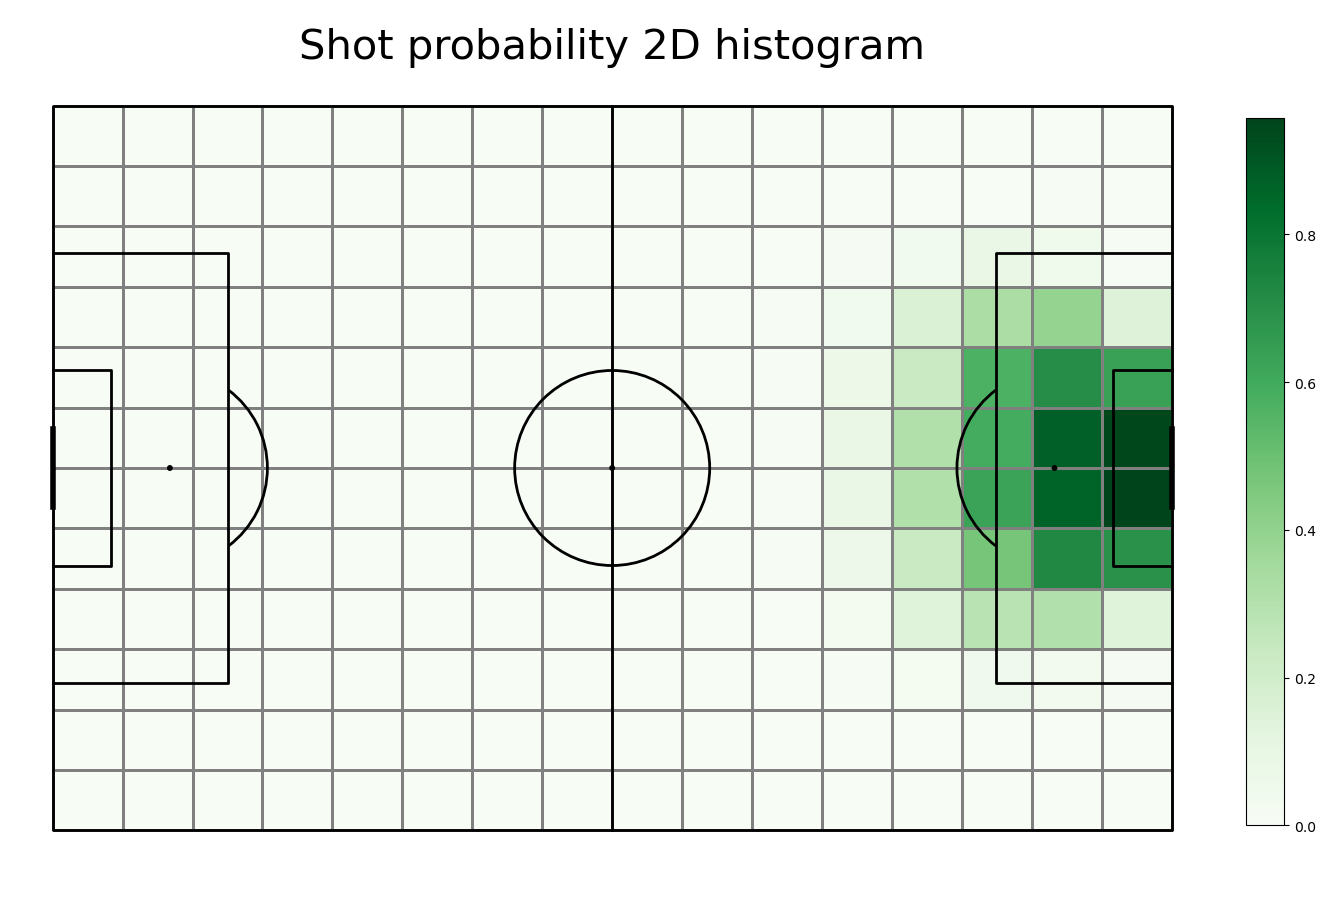

In [33]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

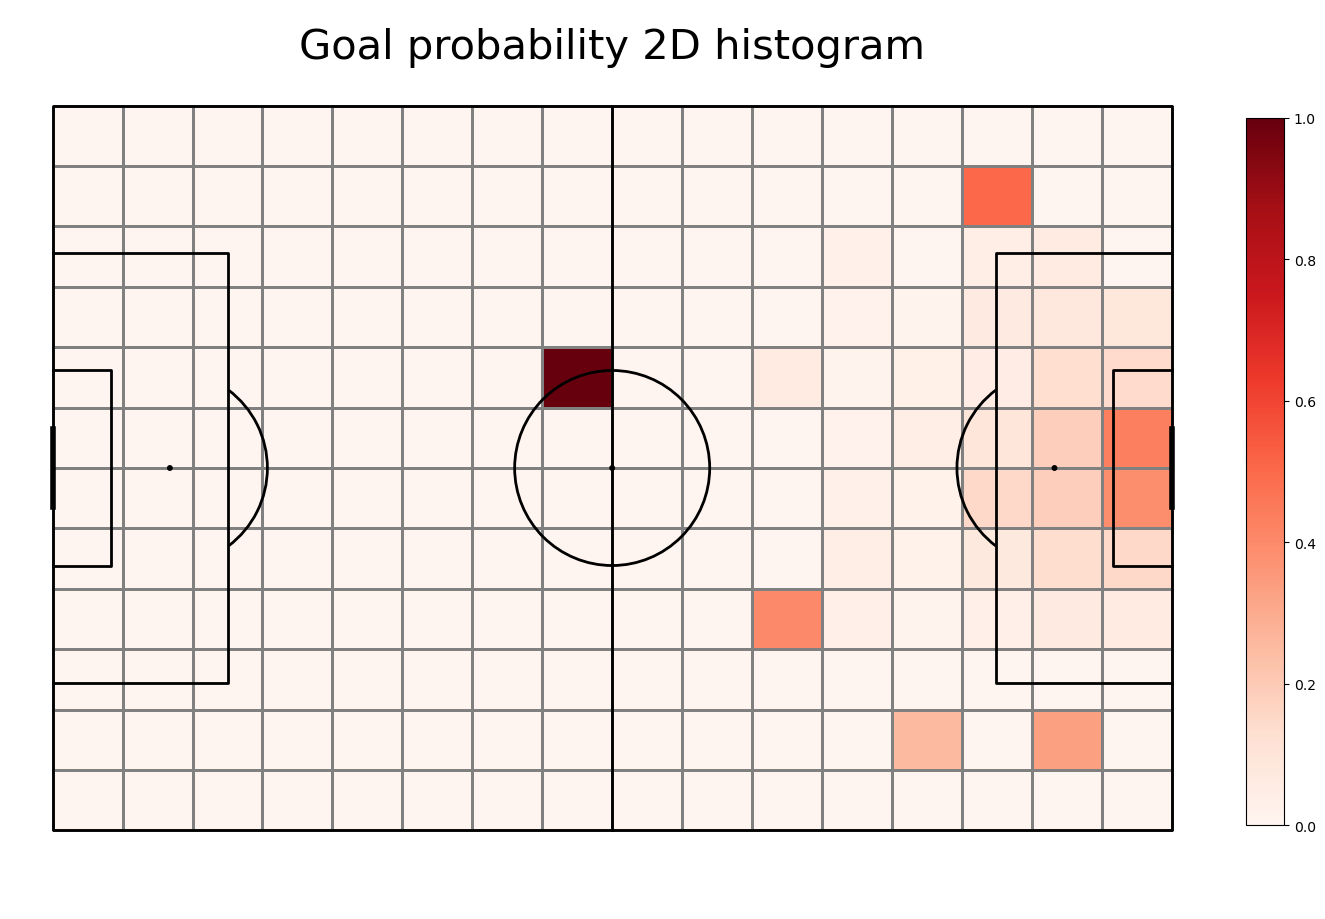

In [34]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()